<a href="https://colab.research.google.com/github/zlisto/opinion_dynamics/blob/main/Multi_Followers_Augmented_Agent_Bang_Bang_Policy_v2_YS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Non-linear Opinion Dynamics with Embedded Agent and Bang Bang Policy 

This notebook solves for an optimal policy for agents trying to minimize a function of the opinions in a network at a given final time under nonlinear opinion dynamics using an augmented agent and a bang bang policy.   We have to specify the network, initial opinions, and tweet rates of the users.  We also specify the agents' rates and targets (followers) in the network.  We specify the opinion shift functions for the opinion dynamics.  We specify the duration and temporal resolution of the opinion dynamics simulator.  And we specify the agents' objective function.




# Import packages

In [2]:
import os
import numpy as np
from scipy import integrate
from scipy.sparse import coo_matrix,diags
import scipy
import math
import matplotlib.pyplot as plt
import networkx as nx
from networkx.readwrite import json_graph

import json

import matplotlib.cm as cm
from matplotlib.colors import Normalize
import seaborn as sns
import pandas as pd
import time

from typing import List, Set, Dict, Tuple


# Mount Google Drive

The data files are located in  the Google Drive path.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/My Drive/Colab Notebooks/ControlTheoryOpinions")
os.listdir()

Mounted at /content/drive


['20210928_1st_year_paper_v8_YS.pdf',
 'test_network_01.json',
 'test_network_02.json',
 'test_network_custom_02.json',
 'test_network_custom_03.json',
 'test_network_custom_01.json',
 'test_network_embed_01.json',
 'test_network_newman_watts_strogatz_01.json',
 'Agent Opinion Bang Bang Solver.ipynb',
 'Input Network for Bang Bang.ipynb',
 'Agent Opinion Augmented Agent Bang Bang Policy.ipynb',
 'test_network_2-follower_01.json',
 'Agent Opinion Augmented Agent Bang Bang Policy_v2_YS.ipynb']

# Helper functions

Functions to simulate the opinion and adjoint dynamics.



1.   step_fast() will make on step forward in the opinion dynamics given current opinions, adjoint variables P, Rates for all users, Followers_list (the network structure), agent_opinion, agent_rate, Targets_index (set of the index of all targets of the agent.  We need the index because we are dealing with arrays for the Opinions and P).
2.   simulate_opinion() will run the opinion dynamics from an initial condition Opinions0 using a time discretization size *tstep* for *nsteps* steps.

3. simulate_adjoint_resverse() will run the *adjoint dynamics* in reverse from a final condition $P_f$, with computed opinions Opinions, using a time discretization size *tstep* for *nsteps* steps.

5. boundary_condition_Pf()

6. objective_value()

7. Plot_opinion_P_quantiles()






In [4]:
def step_fast(Opinions:np.ndarray, P:np.ndarray, Rates:List, A:scipy.sparse.coo.coo_matrix, 
              agent_opinions:List, agent_rates:List, Targets_indices:List):
    n = len(Rates)
    data = shift(Opinions[A.row]- Opinions[A.col],tau,omega) #shift value
    ddata = dshift(Opinions[A.row]- Opinions[A.col],tau,omega) #dshift value
    Shift_matrix = coo_matrix((data, (A.row, A.col)), shape=A.shape) #create shift matrix in coordinate format (row index, col index, value)
    dShift_matrix = coo_matrix((ddata, (A.row, A.col)), shape=A.shape) #create dshift matrix in coordinate format (row index, col index, value)
    Rate_matrix = diags(Rates,0) #create a diagonal matrix with Rates values

    D = Rate_matrix @ Shift_matrix # matrix multiply
    Dxdt_no_agent = D.sum(axis = 0).A1 #contribution from following of node
    dD = Rate_matrix @ dShift_matrix
    dd = dD.sum(axis=0).A1
    L = P*dd #contribution from following of node (its Leaders)
    F = dD @ P  #contribution from followers of node (its Followers)
    Dxdt = Dxdt_no_agent
    Dpdt = L-F

    for (agent_opinion,agent_rate,targets_index) in zip(agent_opinions, agent_rates, Targets_indices):
        b = np.zeros(n)
        b[list(targets_index)]= agent_rate
        Dxdt_agent = b*shift(agent_opinion-Opinions,tau,omega)  #contribution from agent
        Dxdt += Dxdt_agent
        LA = P*b*dshift(agent_opinion-Opinions,tau,omega) #contribution from agent (its Leader Agent)
        Dpdt += LA
    return (Dxdt,Dpdt)

def step_fast_opinions(Opinions:np.ndarray, Rates:List, A:scipy.sparse.coo.coo_matrix, 
              agent_opinions:List, agent_rates:List, Targets_indices:List):
    n = len(Rates)
    data = shift(Opinions[A.row]- Opinions[A.col],tau,omega) #shift value
    ddata = dshift(Opinions[A.row]- Opinions[A.col],tau,omega) #dshift value
    Shift_matrix = coo_matrix((data, (A.row, A.col)), shape=A.shape) #create shift matrix in coordinate format (row index, col index, value)
    dShift_matrix = coo_matrix((ddata, (A.row, A.col)), shape=A.shape) #create dshift matrix in coordinate format (row index, col index, value)
    Rate_matrix = diags(Rates,0) #create a diagonal matrix with Rates values

    D = Rate_matrix @ Shift_matrix # matrix multiply
    Dxdt_no_agent = D.sum(axis = 0).A1 #contribution from following of node
    dD = Rate_matrix @ dShift_matrix
    dd = dD.sum(axis=0).A1
    Dxdt = Dxdt_no_agent

    for (agent_opinion,agent_rate,targets_index) in zip(agent_opinions, agent_rates, Targets_indices):
        b = np.zeros(n)
        b[list(targets_index)]= agent_rate
        Dxdt_agent = b*shift(agent_opinion-Opinions,tau,omega)  #contribution from agent
        Dxdt += Dxdt_agent

    return Dxdt

def simulate_opinion(Opinions0:np.ndarray, Rates:List, A:scipy.sparse.coo.coo_matrix, 
                     Agent_opinions:np.ndarray, agent_rates:List, 
                     Targets_indices:List[List], nsteps:int, tstep:float):
    n =len(Opinions0)
    Opinions = np.zeros((nsteps,n))
    P = np.zeros(n)
    for i in range(nsteps):    
        if i==0:
            Opinions[i,:] = Opinions0
        else:
            agent_opinions = Agent_opinions[i-1,:]
            opinions = Opinions[i-1,:]
            (Dxdt,Dpdt) = step_fast(opinions, P, Rates, A, agent_opinions, agent_rates, Targets_indices)
            opinions_new = opinions+Dxdt*tstep
            opinions_new = np.maximum(np.minimum(opinions_new,np.ones(n)),np.zeros(n))
            Opinions[i,:] = opinions_new
    T = np.arange(0,nsteps*tstep,tstep)
    return (T,Opinions)

def simulate_adjoint_reverse(Pf:np.ndarray, Opinions:np.ndarray, Rates:List, A:scipy.sparse.coo.coo_matrix, 
                             Agent_opinions:np.ndarray, agent_rates:List, Targets_indices:List, 
                             nsteps:int, tstep:float):
    assert Agent_opinions.shape[0]==Opinions.shape[0]
    n =len(Pf)
    P = np.zeros((nsteps,n))

    for i in range(nsteps):  
        if i==0:
            P[nsteps-1-i,:] = Pf
        else:
            agent_opinions = Agent_opinions[nsteps-i,:]
            (Dxdt,Dpdt) = step_fast(Opinions[nsteps-i,:], P[nsteps-i,:], Rates, A, agent_opinions, agent_rates, Targets_indices)
            P[nsteps-1-i,:] = P[nsteps-i,:] - Dpdt*tstep
    T = np.arange(0,nsteps*tstep,tstep)
    return (T,P)

def simulate_opinion_bangbang_one_follower(Opinions0:np.ndarray, Rates:List, A:scipy.sparse.coo.coo_matrix, 
                     agent_rates:List, Targets_indices:List[List], nsteps:int, tstep:float,ts:float):
    n =len(Opinions0)
    nagents = len(Targets_indices)
    Opinions = np.zeros((nsteps,n))
    Opinions_agents= np.zeros((nsteps,nagents))
    for i in range(nsteps):
        t = tstep*i
        if i==0:
            Opinions[i,:] = Opinions0
        else:
            opinions = Opinions[i-1,:]
            agents_opinion=[]
            na = 0
            for targets_indices in Targets_indices:
                agent_opinion = opinions[targets_indices[0]] + tau*np.sign(t-ts)  #agent is conf. bound away from follower
                agent_opinion =min(max(agent_opinion,0),1)
                agents_opinion.append(agent_opinion)
                Opinions_agents[i-1,na] =agent_opinion
                na+=1
            Dxdt = step_fast_opinions(opinions, Rates, A, agents_opinion, agent_rates, Targets_indices)
            opinions_new = opinions+Dxdt*tstep
            opinions_new = np.maximum(np.minimum(opinions_new,np.ones(n)),np.zeros(n))
            Opinions[i,:] = opinions_new
    T = np.arange(0,nsteps*tstep,tstep)
    return (T, Opinions, Opinions_agents)


def boundary_condition_Pf(OBJECTIVE:str, Opinions:np.ndarray, opinion_target = 0.5):
    n = Opinions.shape[1]  #number of nodes in network (not counting agents)
    if OBJECTIVE == "MEAN":
        Pf = -np.ones(n) #final adjoint value for mean objective
    elif OBJECTIVE == "VARIANCE":
        Pf = -(Opinions[-1,:] - np.mean(Opinions[-1,:])) #final adjoint value for variance objective
    elif OBJECTIVE == "TARGET":
        Pf = (Opinions[-1,:] - opinion_target) #final adjoint value for target objective
    return Pf

def objective_value(OBJECTIVE:str,Opinions:np.ndarray,opinion_target=0.5):
    if OBJECTIVE == "MEAN":
        objective = -np.mean(Opinions[-1,:])  #maximize mean
    elif OBJECTIVE == "VARIANCE":
        objective = -np.var(Opinions[-1,:])  #maximize variance
    elif OBJECTIVE == "TARGET":
        objective = np.sqrt(np.mean((Opinions[-1,:]-opinion_target)**2))  #hit a target opinion
    return objective





def plot_opinion_quantiles(T:np.ndarray,Opinions:np.ndarray):
    Q05 = np.quantile(Opinions,0.05,axis = 1)
    Q95 = np.quantile(Opinions,0.95,axis = 1)
    Q50 = np.quantile(Opinions,0.50,axis = 1)
    Q25 = np.quantile(Opinions,0.25,axis = 1)
    Q75 = np.quantile(Opinions,0.75,axis = 1)

    plt.plot(T,Q05,color = 'black')
    plt.plot(T,Q95,color = 'black')
    plt.fill_between(T, Q05, Q95,alpha=0.2)
    plt.plot(T,Q25,color = 'black')
    plt.plot(T,Q75,color = 'black')
    plt.fill_between(T, Q25, Q75,alpha=0.2)
    plt.plot(T,Q50,color = 'blue')
    plt.ylabel('Opinion',fontsize = 18)
    plt.xlabel('Time',fontsize = 18)
    plt.ylim([0,1])



def visualize_network(G0:nx.DiGraph,Opinions0:np.ndarray, Rates:np.ndarray):
    # Visualize network if ain't too big
    G = None
    if G0.number_of_nodes()<=100:
        G = nx.DiGraph()
        for cnt,v in enumerate(G0.nodes()):
            opinion = Opinions0[cnt]
            rate = Rates[cnt]
            G.add_node(v, Name =v, InitialOpinion=opinion, Rate=1)
            followers = G0.successors(v)
        for follower in followers:
            print(f"edge {(v,follower)}")
            G.add_edge(v,follower,weight = rate)

        cnt = 0
        for targets,agent_rate in zip(Targets,agent_rates):
            G.add_node(f"A{cnt}")
        for v in targets:
            G.add_edge(f"A{cnt}",v, weight = agent_rate)
            cnt+=1
            edgewidth = [ 1*d['weight'] for (u,v,d) in G.edges(data=True)]

        pos = nx.kamada_kawai_layout(G)  # positions for all nodes
        pos["Agent"] = (0,-2)
        fig = plt.figure(figsize=(8,8))
        nx.draw(G, pos,width=1.5,node_color="red",edge_color="purple",node_size=500)
        nx.draw_networkx_edges(G, pos, width=edgewidth,edge_color="purple")
        nx.draw_networkx_labels(G, pos,font_size=17,font_color="black")
        fig.set_facecolor("#00000F")
        plt.show()
    else:
        print(f"network has {G0.number_of_nodes()} nodes, too big to draw")
    return G




# Inputs

1) Network information:
>  a) `fname_network` = string name of JSON file containing the input network, tweet rates, and initial opinions of all users


2) Agents/bots information:
>  a) `agents_rates` = list of tweet rates of the agents

>  b) `agents_targets` = list of list of screen names of targets of each agent

3) Opinion dynamics information:
>  a) `omega`, `tau`  = float parameters that specify opinion dynamics

4) Objective function of agent
> a) `OBJECTIVE` = string of type of function of the opinions for the agent to maximize or minimize.  Can take 3 values:MEAN,  VARIANCE, or TARGET 

4) Simulator time parameters
> a) `tmax` = final time for simulation in [time units]

> b) `tstep` = time step for the simulation in [time units]. This is dt in the Euler step.  x(t+tstep) = x(t)+tstep*dx/dt





## Config network

Network has 3 nodes, 2 edges, 1 agents
A: {'opinion': 1.0, 'rate': 1.0}
One: {'opinion': 0.7, 'rate': 1.0}
Two: {'opinion': 0.1, 'rate': 1.0}


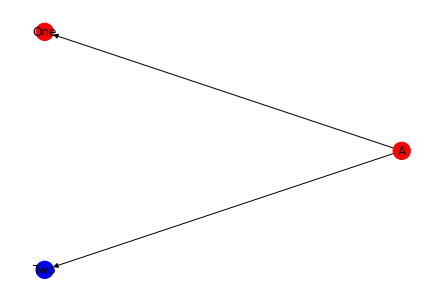

In [5]:
#INPUTS

#Network info
fname_network = "test_network_2-follower_01.json"
agents_rates = [1]
agents_targets = [['A']]

#opinion dynamics info
omega = 1 # strength of persuasion
tau = 0.02 # confidence interval, easiness to pursuade

#objective function 
OBJECTIVE = 'MEAN'  #OBJECTIVE can be "MEAN" (maximize mean), "VARIANCE" (maximize variance), "TARGET" (minimize RMS to target opinion)


# simulation time parameters
tmax = 100  #tmax = tf = final time for simulation in [time units]
tstep = 0.05 #tstep = time step for the simulation in [time units]. This is dt in the Euler step.  x(t+tstep) = x(t)+tstep*dx/dt

INPUT = (fname_network,agents_rates,agents_targets,omega,tau,OBJECTIVE,tmax,tstep)

data = json.load(open(fname_network,'r'))
G0 = json_graph.node_link_graph(data)

#adjacency matrix of network
A = nx.adjacency_matrix(G0)
A = A.tocoo()
n = A.shape[0]  #number of nodes in network
nagents = len(agents_rates)
rates = np.array([G0.nodes[v]["rate"] for v in G0.nodes()])
opinions0 = np.array([G0.nodes[v]["opinion"] for v in G0.nodes()])


print(f"Network has {n} nodes, {G0.number_of_edges()} edges, {nagents} agents")

if n<=50:
    colors = []
    for v in G0.nodes():
        print(f"{v}: {G0.nodes[v]}")
        if G0.nodes[v]['opinion']<=0.5:
            colors.append('blue')
        else:
            colors.append('red')
    pos = nx.kamada_kawai_layout(G0)
    nx.draw(G0,pos, node_color = colors)
    nx.draw_networkx_labels(G0,pos)

## Shift function

Create function that gives the opinion shift and derivative of the opinion shift in the opinion dynamics.     For the opinion dynamics these functions are shift and dshift, respectively. You can have extra parameters for these functions, but the first argument is the opinion difference between the following and follower.  To be precise, if the opinion of the person tweeting
is $\theta_{tweet}$ and the opinion of the person who hears the tweet is $\theta$, then the input to the shift and dshift functions should be $x = \theta_{tweet}-\theta$. 

We define `shift_max` as the maximum of the shift function.  We need this when we solve for the bang bang policy of the agent.

 



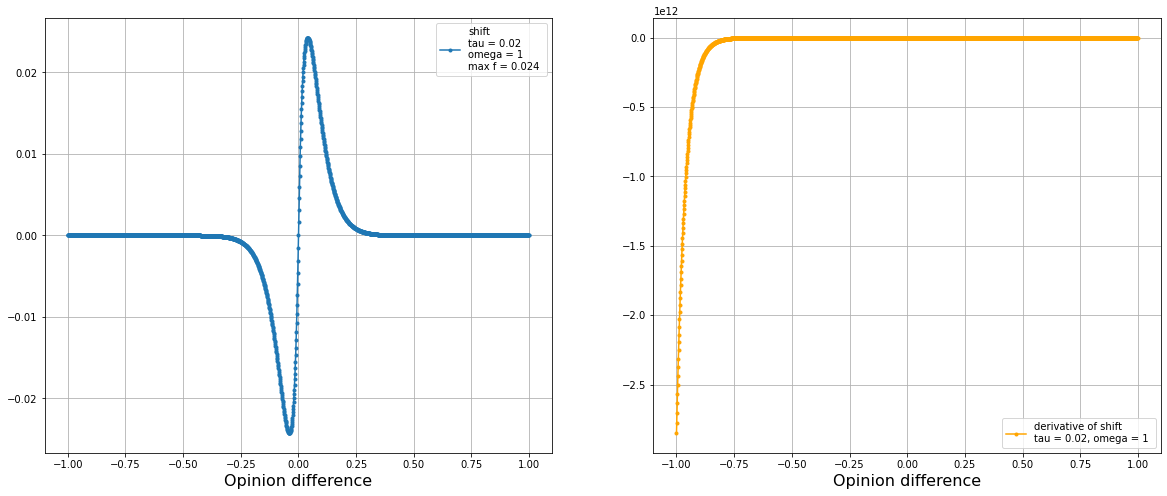

In [6]:
confidence_bound_decay = 1
#shift function f
def shift(x,tau,omega):
    y = omega *x*np.exp(-np.abs(x/tau)**confidence_bound_decay/2+1/2)
    #y = omega*x*(np.heaviside(x+tau,1)-np.heaviside(x-tau,0))
    return(y)

#derivative of shift function g
def dshift(x,tau,omega):
    y = omega*np.exp(-(x/tau)**confidence_bound_decay/2+1/2)*(1-confidence_bound_decay/2*np.abs(x/tau)**(confidence_bound_decay))
    return(y)


x = np.arange(-1,1,.001)
shift_max = np.max(shift(x,tau,omega))


#plot the shift function to see how it looks
plt.figure(figsize =(20,8))
plt.subplot(1,2,1)
plt.plot(x,shift(x,tau,omega),label = f'shift\ntau = {tau}\nomega = {omega}\nmax f = {shift_max:.3f} ',marker='.')
plt.legend()
plt.xlabel('Opinion difference',fontsize = 16)
plt.grid()

plt.subplot(1,2,2)
plt.plot(x,dshift(x,tau,omega),label = f'derivative of shift\ntau = {tau}, omega = {omega} ',color = 'orange',marker='.')
plt.legend()
plt.xlabel('Opinion difference',fontsize = 16)
plt.grid()
plt.show()

# Embed Augmented Agents to Network

Create a network `Gembed` which has the augmented agents embedded in the network.  You will also create variables `Aembed`, `rates_embed`, `opinions0_embed`.

A: {'opinion': 1.0, 'rate': 1.0}
One: {'opinion': 0.7, 'rate': 1.0}
Two: {'opinion': 0.1, 'rate': 1.0}
AA_0: {'opinion': 0.5, 'rate': 1}


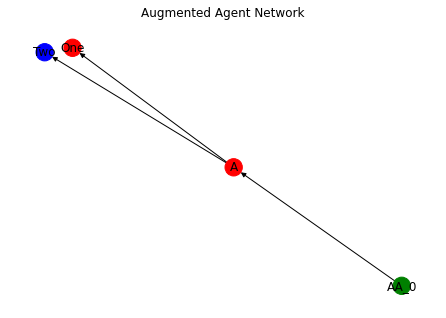

In [7]:
agents_targets_embed = []
agents_rates_embed = []

Gagent = nx.DiGraph()
for cnt,targets in enumerate(agents_targets):
    agent = f"AA_{cnt}"
    agents_targets_embed.append([agent])
    Gagent.add_node(agent)
    Gagent.nodes[agent]["opinion"] = 0.5
    Gagent.nodes[agent]["rate"] = agents_rates[cnt]
    agents_rates_embed.append(1)
    for target in targets:
        Gagent.add_edge(agent,target)

Gembed = nx.compose(G0,Gagent)

#adjacency matrix of network
Aembed = nx.adjacency_matrix(Gembed)
Aembed = Aembed.tocoo()
n_embed = Aembed.shape[0]  #number of nodes in augmented network
rates_embed = np.array([Gembed.nodes[v]["rate"] for v in Gembed.nodes()])
opinions0_embed = np.array([Gembed.nodes[v]["opinion"] for v in Gembed.nodes()])

if n<=50:
    colors = []
    for v in Gembed.nodes():
        print(f"{v}: {Gembed.nodes[v]}")
        if "AA_" in v:
            color = 'green'
        elif Gembed.nodes[v]['opinion']<=0.5:
            color = 'blue'
        else:
            color = 'red'
        colors.append(color)
          
    pos = nx.kamada_kawai_layout(Gembed)
    nx.draw(Gembed,pos, node_color = colors)
    nx.draw_networkx_labels(Gembed,pos)
    plt.title("Augmented Agent Network")

# Define Node Indices in Augmented Network

The simulator needs indices for each node, i.e. 0, 1, 2, ...  This code creates a dictionary with keys being node names and values being the indices.

In [8]:
#create node_index and followers_list for simulator
node_index = {}
node_screen_name = list(Gembed.nodes())
for cnt,v in enumerate(Gembed.nodes()):
    node_index[v] = cnt

if len(node_index)<10:
    print(node_index)

{'A': 0, 'One': 1, 'Two': 2, 'AA_0': 3}


# Agent Targets Index in Augmented Agent Network
        
We create a list `agents_targets_indices` that puts in the index for the nodes for the simulator (the simulator does not use screen names, but numerical indices for the nodes).

In [9]:
nagents= len(agents_rates_embed)
assert len(agents_rates_embed)==len(agents_targets_embed)

# create target indices for simulator
agents_targets_indices = []
for agent_targets in agents_targets_embed:
    agent_targets_indices = []
    for v in agent_targets:
        agent_targets_indices.append(node_index[v])
    agents_targets_indices.append(agent_targets_indices)

agents_targets_indices

[[3]]

# Set Simulation Time Parameters

`din_max` is the maximum in-degree in the network.  `opinion_rate` is and estimate of the largest rate of change of the opinions of a user in the network.  This rate lets us figure out the simulator's temporal resolution.

`tmax_theory` is an estimate of how much time is needed to pull the mean opinion from zero to one.  This gives a ballpark value for how long the simulation should be run.

We want `tmax` to be near `tmax_theory` and `tstep` to be less than `tstep_theory`.

In [10]:
din_max = max([x[1] for x in G0.in_degree(G0.nodes())])
opinion_rate = din_max*max(agents_rates)
opinion_shift_resolution = 0.05
tstep_theory = opinion_shift_resolution/(shift_max*din_max*max(agents_rates))

opinion_mean_rate = shift_max*max(agents_rates)/n
ts_theory = 1/opinion_mean_rate
tmax_theory = 2*ts_theory


print(f"tmax theory = {tmax_theory:.3f}")
print(f"tstep theory = {tstep_theory:.3f}")


print(f"Simuation runs from 0<t<{tmax} with tstep = {tstep}")

# Simulator Settings
# Set `nsteps`, the number of discrete steps in the simulator.

#Choose objective:  this will be minimized by the agent
nsteps = np.int(tmax/tstep)  #number of discrete steps in the simulation

print(f"Simulator runs from 0<=t<={tmax} for {nsteps} steps\nStep size = {tstep}")

tmax theory = 247.308
tstep theory = 2.061
Simuation runs from 0<t<100 with tstep = 0.05
Simulator runs from 0<=t<=100 for 2000 steps
Step size = 0.05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


# Run simulation with no agent

Run the opinion dynamics simulation with no agents.  This let's you see if the time scale and step for the simulation are ok.

Simuator takes 3.2766004360000007 seconds
no agent objective =-0.613744


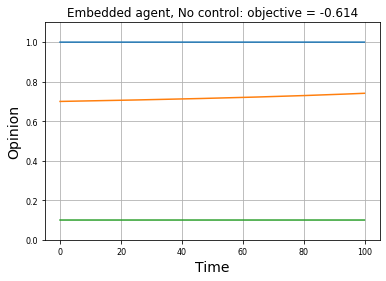

In [11]:
start = time.process_time()
(T,Opinions_no_agent) = simulate_opinion(opinions0, rates, A, 
                                          np.ones((nsteps,nagents)), 
                                         agents_rates, [], nsteps, tstep)
tsim = time.process_time() - start
print(f"Simuator takes {tsim} seconds")
obj_no_agent = objective_value(OBJECTIVE,Opinions_no_agent)
print(f"no agent objective ={obj_no_agent:.6f}")

#plot the opinions
if n>=100:
    plot_opinion_quantiles(T,Opinions_no_agent)
else:
    plt.plot(T,Opinions_no_agent)


plt.title(f"Embedded agent, No control: objective = {obj_no_agent:.3f}", fontsize = 12)
plt.ylabel('Opinion',fontsize = 14)
plt.xlabel('Time',fontsize = 14)
plt.ylim([0,1.1])
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.grid()

# Solve for Bang Bang Policy with Augmented Agent

The Bang Bang policy with an augmented agent has two parameters:  
   
       1) The value of $t$ when the agent opinion flips: `ts` in the code
       
       2) The initial opinion of the real (non-augmented) agent: `u` in the code

The augmented agent's bang bang policy will initially descend/ascend linearly until time $t_s$, then do the opposite afterwards.  The augmented agent always tracks the original agent that follows it.

In [12]:
#%%time
T = np.linspace(0,tmax,nsteps)
obj_best = np.inf
n_ts = 10

ts_theory = (1-tau)/(tau*agents_rates_embed[0]*omega)
print(f"Theory optimal ts = {ts_theory:.6f}")
delta = 0.25
ts_min =  0 #ts_theory*(1-delta)
ts_max =  100 # ts_theory*(1+delta)
dts = ts_max - ts_min
Ts = np.arange(ts_min,ts_max,dts/n_ts)

U = np.linspace(0,1,10)
n_theta0 = len(U)
Result = np.zeros((n_ts*n_theta0,3))

print(f"Optimization will take {n_ts*n_theta0*tsim} seconds to run")
print("\tobjective\tts\tu(0)")
c=0
for u in U:
    opinions0_embed[node_index['AA_0']] = u
    for ts in Ts:
        # Bang Bang with embedded agent
        (T,Opinions,z_opinions) = simulate_opinion_bangbang_one_follower(opinions0_embed, 
                                                                rates_embed, 
                                                                Aembed, 
                                                                agents_rates_embed, 
                                                                agents_targets_indices, 
                                                                nsteps, tstep,ts)
        obj = objective_value(OBJECTIVE,Opinions)
        # Result[c,:] = np.array([ts,theta0_embed,obj])
        #print(f"{obj:.6f}\t{ts:.2f}\t{theta0_embed:.2f}")
        c+=1
        if obj<=obj_best:
            obj_best = obj
            z_opinions_best = z_opinions
            ts_best = ts
            u_best = u
            print(f"New best: {obj:.6f}\t{ts:.2f}\t{u:.2f}")

print("\nUpdate embedded agent initial opinion with best value (for simulator)")
opinions0_embed[node_index['AA_0']] = u_best        

Theory optimal ts = 49.000000
Optimization will take 327.66004360000005 seconds to run
	objective	ts	u(0)
New best: -0.713268	0.00	0.00
New best: -0.713278	0.00	0.11
New best: -0.713287	0.00	0.22
New best: -0.713295	0.00	0.33
New best: -0.713303	0.00	0.44
New best: -0.713306	0.00	0.56
New best: -0.713358	10.00	0.67
New best: -0.714042	10.00	0.78
New best: -0.714373	20.00	0.78
New best: -0.714681	30.00	0.78
New best: -0.714955	40.00	0.78
New best: -0.749450	10.00	0.89
New best: -0.775000	20.00	0.89
New best: -0.775000	30.00	0.89
New best: -0.775000	40.00	0.89
New best: -0.775000	10.00	1.00
New best: -0.775003	20.00	1.00
New best: -0.775288	30.00	1.00
New best: -1.000000	40.00	1.00

Update embedded agent initial opinion with best value (for simulator)


# Calculate outputs

Simulate opinion dynamics with embedded agent with optimal initial opinion and optimal switching time for control agent.

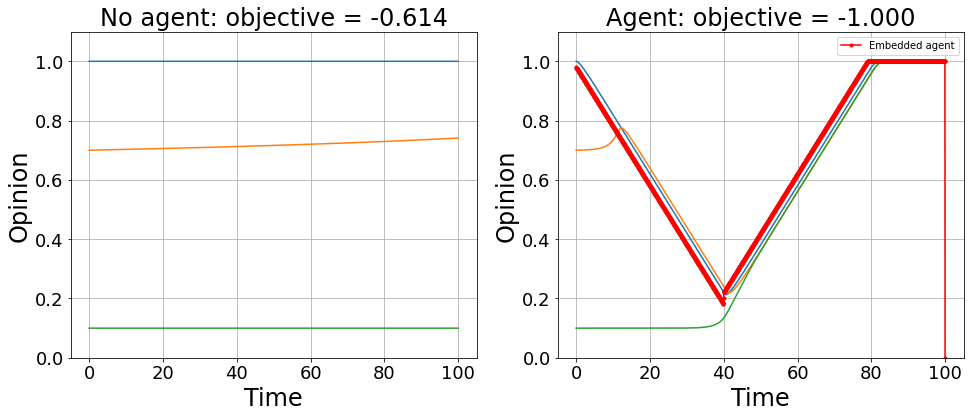

In [18]:
(T,embed_Opinions_optimized) = simulate_opinion(opinions0_embed, rates_embed, Aembed, 
                                          z_opinions_best, agents_rates_embed, 
                                          agents_targets_indices, nsteps, tstep)

#keep only original users/agents in Opinions array
Opinions_optimized  = np.delete(embed_Opinions_optimized, node_index['AA_0'], 1)
#agents_opinions_best is opinion of control agent, not embedded agent
agents_opinions_best = np.reshape(embed_Opinions_optimized[:,node_index['AA_0']],(embed_Opinions_optimized.shape[0],1))

OUTPUT = (T,Opinions_no_agent,Opinions_optimized,agents_opinions_best)

# Plot opinions without and with trained agent
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
if n>=100:
    plot_opinion_quantiles(T,Opinions_no_agent)
else:
    plt.plot(T,Opinions_no_agent)


plt.title(f"No agent: objective = {obj_no_agent:.3f}", fontsize = 24)
plt.ylabel('Opinion',fontsize = 24)
plt.xlabel('Time',fontsize = 24)
plt.ylim([0,1.1])
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid()

plt.subplot(1,2,2)
if n>=100:
    plot_opinion_quantiles(T,Opinions_optimized)
else:
    plt.plot(T,Opinions_optimized)
#plot actual agents' opinions  
# for i in range(nagents):
#     agents_opinions_best[-1,i] = agents_opinions_best[-2,i]
#     plt.plot(T,agents_opinions_best[:,i],marker='.',label=f'A',color ='black')

# plot embedded agent opinions (this agent is not actually in the network)
# plt.plot(T,embed_agents_opinions_best,
#         marker='.',label=f'Embedded agent',color ='red')

# plot embedded agent opinions (this agent is not actually in the network)
plt.plot(T,z_opinions_best,marker='.',label=f'Embedded agent',color ='red')

plt.title(f"Agent: objective = {obj_best:.3f}", fontsize = 24)
plt.ylabel('Opinion',fontsize = 24)
plt.xlabel('Time',fontsize = 24)
plt.legend()
plt.ylim([0,1.1])
#plt.xlim([0,40])
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid()
plt.show()

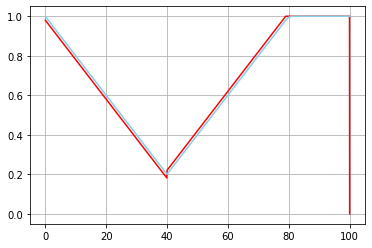

In [21]:
plt.plot(T,z_opinions_best,label=f'Embedded agent',color = 'red')
plt.plot(T,agents_opinions_best[:,0],label=f'A',color ='skyblue')
plt.grid()
plt.show()